In [13]:
from os.path import join, exists
from os import makedirs
from scipy.stats import pearsonr, kendalltau
from mne.stats import bonferroni_correction, fdr_correction
from utils import subjects
from brainpipe.system import study
import numpy as np
from itertools import product
import pandas as pd

In [91]:
"""
Correlate RDMs of HC and OFC in patients with both ROIs
>> show any link between integration in HC and segregation in OFC
>> Analysis with all trials OR through time Early & Late 
"""

st = study('Olfacto')
exp = 'Enc'#'Enc'
cond = 'high' #freqname in filename
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all/')
filename = join(path_pow, 'npz/TPS_pearson_{}_{}_theta_btw_odors_mean=False_sheet_Final.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_aHC_OFC_all_elecs_{}.csv')

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals, p_vals, pvals_fdr = [], [], []

for su in subjects:
    mat = np.load(filename.format(su,cond),allow_pickle=True)
    log_su = [1 if all(i in mat['labels'] for i in ['aHC','OFC_olf']) else 0]
    
    #select only subjects with HC and OFC electrodes
    if log_su == [1]: 
        idx_HC = [i for i,lab in enumerate(mat['labels']) if lab == 'aHC']
        idx_OFC = [i for i,lab in enumerate(mat['labels']) if lab == 'OFC_olf']
        print('>> processing', su, len(idx_HC),'elecs in aHC &',
                len(idx_OFC), 'elecs in OFC_olf')
                
        p_su = [] #correct for multiple comparisons by subj
        #create all pairs of comparisons between ROIs
        for e1, e2 in product(idx_HC, idx_OFC):
            tps_HC, tps_OFC = mat['tps'][e1,:], mat['tps'][e2,:]
            R, p = kendalltau(tps_HC,tps_OFC)
            
            #append df (all info by elec)
            subjs.append(su), elecs.append(str(e1)+'_'+str(e2))
            channels.append(mat['channels'][e1]+'/'+mat['channels'][e2])
            R_vals.append(R), p_su.append(p)
        
        p_su_fdr = fdr_correction(p_su)[1]
        p_vals.extend(p_su), pvals_fdr.extend(p_su_fdr)
    
data = np.concatenate((np.array(subjs)[:,np.newaxis], np.array(elecs)[:,np.newaxis], 
                   np.array(channels)[:,np.newaxis],np.array(R_vals)[:,np.newaxis], 
                   np.array(p_vals)[:,np.newaxis], np.array(pvals_fdr)[:,np.newaxis]),axis=1)
df = pd.DataFrame(data, columns=['subjs', 'elecs', 'channels','R_vals', 
                                 'p_vals', 'pvals_fdr'])
df.to_csv(save_df.format(cond))

#check sig results
df['pvals_fdr'] = df['pvals_fdr'].astype(float)
df['p_vals'] = df['p_vals'].astype(float)
df['R_vals'] = df['R_vals'].astype(float)
df2 = df.loc[df['R_vals']<0]
df2 = df2.loc[df2['p_vals']<0.05]

df3 = df.loc[df['R_vals']>0]
df3 = df3.loc[df3['p_vals']<0.05]

print(df2)
print(df3)

-> Olfacto loaded
>> processing LEFC 8 elecs in aHC & 5 elecs in OFC_olf
>> processing SEMC 5 elecs in aHC & 3 elecs in OFC_olf
>> processing VACJ 8 elecs in aHC & 4 elecs in OFC_olf
>> processing PIRJ 7 elecs in aHC & 4 elecs in OFC_olf
    subjs elecs         channels    R_vals    p_vals  pvals_fdr
5    LEFC  2_17      b3-b2/o3-o2 -0.177305  0.011362   0.126967
6    LEFC  2_18      b3-b2/o4-o3 -0.159003  0.023204   0.180116
22   LEFC  5_19      d3-d2/o5-o4 -0.211622  0.002517   0.050338
25   LEFC  6_17      d4-d3/o3-o2 -0.142988  0.041209   0.188996
44   SEMC  1_23      b3-b2/o6-o5 -0.327635  0.016426   0.246393
82   VACJ  6_36  b'5-b'4/o'8-o'7 -0.353846  0.010950   0.133393
94   PIRJ  1_15      b3-b2/o7-o6 -0.165422  0.012827   0.070002
105  PIRJ  4_14    b'3-b'2/o6-o5 -0.166169  0.012427   0.070002
    subjs elecs       channels    R_vals    p_vals  pvals_fdr
18   LEFC  4_20    d2-d1/o6-o5  0.154884  0.027017   0.180116
28   LEFC  6_20    d4-d3/o6-o5  0.142073  0.042524   0.188996


In [285]:
"""
Correlate RDMs of HC and OFC in patients with both ROIs
LATE - EARLY (after discussing with Karim)
>> show any link between integration in HC and segregation in OFC
>> Analysis with all trials OR through time Early & Late 
"""

st = study('Olfacto')
exp = 'Enc'#'Enc'
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all_early_late/')
filename = join(path_pow, 'TPS_pearson_{}_theta_btw_odors_mean=False_sheet_Final_{}.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_DIFF_aHC_OFC_all_elecs.csv')

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals_diff, p_vals_diff, pvals_fdr_diff = [], [], []
R_vals_norm, p_vals_norm, pvals_fdr_norm = [], [], []

for su in subjects:
    mat = np.load(filename.format(su,'early'),allow_pickle=True)
    mat2 = np.load(filename.format(su,'late'),allow_pickle=True)
    log_su = [1 if all(i in mat['labels'] for i in ['aHC','OFC_olf']) else 0]
        
    #select only subjects with HC and OFC electrodes
    if log_su == [1]: 
        idx_HC = [i for i,lab in enumerate(mat['labels']) if lab == 'aHC']
        idx_OFC = [i for i,lab in enumerate(mat['labels']) if lab == 'OFC_olf']
        print('>> processing', su, len(idx_HC),'elecs in aHC &',
                len(idx_OFC), 'elecs in OFC_olf')
                
        p_su_diff, p_su_norm = [], [] #correct for multiple comparisons by subj
        #create all pairs of comparisons between ROIs
        for e1, e2 in product(idx_HC, idx_OFC):
            
            #create df to group by odors and average
            dataE = np.concatenate((mat['tps'][e1,:][:,np.newaxis],
                                    mat['tps'][e2,:][:,np.newaxis],
                                    mat['comb'][:,np.newaxis]),axis=1)
            dataL = np.concatenate((mat2['tps'][e1,:][:,np.newaxis],
                                    mat2['tps'][e2,:][:,np.newaxis],
                                    mat2['comb'][:,np.newaxis]),axis=1)
            dfE = pd.DataFrame(dataE, columns = ['tps_e1','tps_e2','combs'])
            dfL = pd.DataFrame(dataL, columns= ['tps_e1','tps_e2','combs'])
            for col in ['tps_e1','tps_e2']:
                dfE[col] = dfE[col].astype(float)
                dfL[col] = dfL[col].astype(float)
            dfE = dfE.groupby(['combs'],as_index=False).first()
            dfL = dfL.groupby(['combs'],as_index=False).last()

            #check whether same odors are present in both early and late
            if not dfE.shape == dfL.shape:
                dfE = dfE[dfE["combs"].isin(dfL["combs"])]
            diff_HC = dfL['tps_e1'].values - dfE['tps_e1'].values
            diff_OFC = dfL['tps_e2'].values - dfE['tps_e2'].values
            R_diff, p_diff = kendalltau(diff_HC,diff_OFC)
            
            norm_HC = (dfE['tps_e1'].values - dfL['tps_e1'].values) / dfL['tps_e1'].values
            norm_OFC = (dfE['tps_e2'].values - dfL['tps_e2'].values) / dfL['tps_e2'].values
            R_norm, p_norm = kendalltau(norm_HC,norm_OFC)
            
            #append df (all info by elec)
            subjs.append(su), elecs.append(str(e1)+'_'+str(e2))
            channels.append(mat['channels'][e1]+'/'+mat['channels'][e2])
            R_vals_diff.append(R_diff), p_su_diff.append(p_diff)
            R_vals_norm.append(R_norm), p_su_norm.append(p_norm)
        
        p_su_fdr_diff = fdr_correction(p_su_diff)[1]
        p_su_fdr_norm = fdr_correction(p_su_norm)[1]
        p_vals_diff.extend(p_su_diff), pvals_fdr_diff.extend(p_su_fdr_diff)
        p_vals_norm.extend(p_su_norm), pvals_fdr_norm.extend(p_su_fdr_norm)

data = np.concatenate((np.array(subjs)[:,np.newaxis], np.array(elecs)[:,np.newaxis], 
                np.array(channels)[:,np.newaxis],np.array(R_vals_diff)[:,np.newaxis], 
            np.array(p_vals_diff)[:,np.newaxis], np.array(pvals_fdr_diff)[:,np.newaxis],
                np.array(R_vals_norm)[:,np.newaxis],np.array(p_vals_norm)[:,np.newaxis],
                np.array(pvals_fdr_norm)[:,np.newaxis]),axis=1)
df = pd.DataFrame(data, columns=['subjs', 'elecs', 'channels','R_vals_diff','pvals_diff',
                         'pvals_fdr_diff', 'R_vals_norm', 'pvals_norm', 'pvals_fdr_norm'])
df.to_csv(save_df.format(cond))

#check sig results
cols = ['R_vals_diff','pvals_diff','pvals_fdr_diff','R_vals_norm','pvals_norm',
        'pvals_fdr_norm']
for c in cols:
    df[c] = df[c].astype(float)
df_neg = df.loc[(df['R_vals_norm']<0) & (df['pvals_norm']<0.05)]
df_pos = df.loc[(df['R_vals_norm']>0) &(df['pvals_norm']<0.05)]
print(df_neg)
print(df_pos)

-> Olfacto loaded
>> processing LEFC 8 elecs in aHC & 5 elecs in OFC_olf
>> processing SEMC 5 elecs in aHC & 3 elecs in OFC_olf
>> processing VACJ 8 elecs in aHC & 4 elecs in OFC_olf
>> processing PIRJ 7 elecs in aHC & 4 elecs in OFC_olf
   subjs elecs     channels  R_vals_diff  pvals_diff  pvals_fdr_diff  \
5   LEFC  2_17  b3-b2/o3-o2    -0.253968     0.06006        0.523797   
95  PIRJ  2_12  b4-b3/o2-o1    -0.504762     0.00827        0.231560   

    R_vals_norm  pvals_norm  pvals_fdr_norm  
5     -0.285714    0.033612        0.672231  
95    -0.523810    0.005902        0.165244  
   subjs elecs     channels  R_vals_diff  pvals_diff  pvals_fdr_diff  \
22  LEFC  5_19  d3-d2/o5-o4     0.275132    0.041054        0.523797   

    R_vals_norm  pvals_norm  pvals_fdr_norm  
22     0.328042    0.014103        0.564127  


In [281]:
"""
Correlate RDMs of HC and OFC in patients with both ROIs
HIGH - LOW (after LATER-BEFORE not working)
>> show any link between integration in HC and segregation in OFC
>> Analysis with all trials (all diff comparisons)
"""

st = study('Olfacto')
exp = 'Enc'#'Enc'
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all/')
filename = join(path_pow, 'npz/TPS_pearson_{}_{}_theta_btw_odors_mean=False_sheet_Final.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_DIFF_aHC_OFC_all_elecs_LH.csv')

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals_diff, p_vals_diff, pvals_fdr_diff = [], [], []
R_vals_norm, p_vals_norm, pvals_fdr_norm = [], [], []

for su in subjects:
    mat = np.load(filename.format(su,'low'),allow_pickle=True)
    mat2 = np.load(filename.format(su,'high'),allow_pickle=True)
    log_su = [1 if all(i in mat['labels'] for i in ['aHC','OFC_olf']) else 0]
        
    #select only subjects with HC and OFC electrodes
    if log_su == [1]: 
        idx_HC = [i for i,lab in enumerate(mat['labels']) if lab == 'aHC']
        idx_OFC = [i for i,lab in enumerate(mat['labels']) if lab == 'OFC_olf']
        print('>> processing', su, len(idx_HC),'elecs in aHC &',
                len(idx_OFC), 'elecs in OFC_olf')
                
        p_su_diff, p_su_norm = [], [] #correct for multiple comparisons by subj
        #create all pairs of comparisons between ROIs
        for e1, e2 in product(idx_HC, idx_OFC):
            data_L, combL = mat['tps'][[e1,e2],:], mat['comb']
            data_H, combH = mat2['tps'][[e1,e2],:], mat2['comb']
            ntrialsL, ntrialsH = data_L.shape[-1], data_H.shape[-1]
            #print(su,data_L.shape,data_H.shape,combL.shape,combH.shape)
            
            #create all comparisons (diff or norm) for e1 & e2
            combs_LH, diff_LH_e1, norm_LH_e1 = [],[],[]
            diff_LH_e2, norm_LH_e2 = [],[]
            for t1, t2 in product(range(ntrialsL),range(ntrialsH)):
                combs_LH.append(combL[t1]+'_'+combH[t2])
                #print(t1,t2,combL[t1],combH[t2])
                diff_LH_e1.append((data_H[0,t2] - data_L[0,t1]))
                norm_LH_e1.append((data_H[0,t2] - data_L[0,t1])/data_L[0,t1])
                diff_LH_e2.append((data_H[1,t2] - data_L[1,t1]))
                norm_LH_e2.append((data_H[1,t2] - data_L[1,t1])/data_L[1,t1])
               #create a df with all comparisons (id, vals for e1 & e2)
            data_df = np.concatenate((np.array(combs_LH)[:,np.newaxis],
                                      np.array(diff_LH_e1)[:,np.newaxis],
                                      np.array(norm_LH_e1)[:,np.newaxis],
                                      np.array(diff_LH_e2)[:,np.newaxis],
                                      np.array(norm_LH_e2)[:,np.newaxis]),axis=1)
            df_LH = pd.DataFrame(data_df, columns = ['combs',
                                'diff_e1','norm_e1','diff_e2','norm_e2'])
            for col in ['diff_e1','norm_e1','diff_e2','norm_e2']:
                df_LH[col] = df_LH[col].astype(float)
            #df_LH = df_LH.groupby(['combs'],as_index=False).mean()
            
            #compute Kendall correlations between RDMs
            R_diff, p_diff = kendalltau(df_LH['diff_e1'].values,df_LH['diff_e2'].values)
            R_norm, p_norm = kendalltau(df_LH['norm_e1'].values,df_LH['norm_e2'].values)
            
            #append df (all info by elec)
            subjs.append(su), elecs.append(str(e1)+'_'+str(e2))
            channels.append(mat['channels'][e1]+'/'+mat['channels'][e2])
            R_vals_diff.append(R_diff), p_su_diff.append(p_diff)
            R_vals_norm.append(R_norm), p_su_norm.append(p_norm)
        
        p_su_fdr_diff = fdr_correction(p_su_diff)[1]
        p_su_fdr_norm = fdr_correction(p_su_norm)[1]
        p_vals_diff.extend(p_su_diff), pvals_fdr_diff.extend(p_su_fdr_diff)
        p_vals_norm.extend(p_su_norm), pvals_fdr_norm.extend(p_su_fdr_norm)

data = np.concatenate((np.array(subjs)[:,np.newaxis], np.array(elecs)[:,np.newaxis], 
                np.array(channels)[:,np.newaxis],np.array(R_vals_diff)[:,np.newaxis], 
            np.array(p_vals_diff)[:,np.newaxis], np.array(pvals_fdr_diff)[:,np.newaxis],
                np.array(R_vals_norm)[:,np.newaxis],np.array(p_vals_norm)[:,np.newaxis],
                np.array(pvals_fdr_norm)[:,np.newaxis]),axis=1)
df = pd.DataFrame(data, columns=['subjs', 'elecs', 'channels','R_vals_diff','pvals_diff',
                         'pvals_fdr_diff', 'R_vals_norm', 'pvals_norm', 'pvals_fdr_norm'])
df.to_csv(save_df.format(cond))

#check sig results
cols = ['R_vals_diff','pvals_diff','pvals_fdr_diff','R_vals_norm','pvals_norm',
        'pvals_fdr_norm']
for c in cols:
    df[c] = df[c].astype(float)
#df_neg = df.loc[(df['R_vals_norm']<0) & (df['pvals_fdr_norm']<0.001)]
#df_pos = df.loc[(df['R_vals_norm']>0) & (df['pvals_fdr_norm']<0.001)]
#print(df_neg.shape,np.unique(df_neg['subjs']))
#print(df_pos.shape, np.unique(df_pos['subjs']))

-> Olfacto loaded
>> processing LEFC 8 elecs in aHC & 5 elecs in OFC_olf
>> processing SEMC 5 elecs in aHC & 3 elecs in OFC_olf
>> processing VACJ 8 elecs in aHC & 4 elecs in OFC_olf
>> processing PIRJ 7 elecs in aHC & 4 elecs in OFC_olf


In [284]:
su_elec_sig = {'LEFC':{'aHC':['b2-b1','b4-b3','d4-d3','d5-d4'],
                      'OFC':['o7-o6']},
               'SEMC':{'aHC':['b2-b1'],
                      'OFC':['o5-o4']},
               'PIRJ':{'aHC':[],
                       'OFC':['o5-o4','o6-o5','o7-o6']}}

for su in ['LEFC','SEMC']:
    eHC = su_elec_sig[su]['aHC']
    eOFC = su_elec_sig[su]['OFC']
    c_take = [e1+'/'+e2 for e1,e2 in product(eHC,eOFC)]
    print(df[['subjs','channels','R_vals_norm','pvals_norm',
              'pvals_fdr_norm']].loc[df['subjs']==su].loc[df['channels'].isin(c_take)])


   subjs     channels  R_vals_norm    pvals_norm  pvals_fdr_norm
4   LEFC  b2-b1/o7-o6     0.055710  3.634724e-19    9.692598e-19
14  LEFC  b4-b3/o7-o6     0.008125  1.919342e-01    2.020360e-01
29  LEFC  d4-d3/o7-o6     0.072093  5.278063e-31    2.111225e-30
34  LEFC  d5-d4/o7-o6     0.076270  1.688588e-34    8.442942e-34
   subjs     channels  R_vals_norm    pvals_norm  pvals_fdr_norm
40  SEMC  b2-b1/o5-o4    -0.058718  7.711829e-08    1.927957e-07


In [97]:
"""
SAME ANALYSIS but only on sig. electrodes (Fig.2)
>> Only 2 patients have SIG elecs in both ROIs
>> Analysis with all trials OR through time Early & Late 
"""

st = study('Olfacto')
exp = 'Enc'#'Enc'
cond = 'late' #freqname in filename
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all_early_late/')
filename = join(path_pow, 'TPS_pearson_{}_theta_btw_odors_mean=False_sheet_Final_late.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_aHC_OFC_all_elecs_3patients_late.csv')

#dict of sig elecs by patient
su_elec_sig = {'LEFC':{'aHC':['b2-b1','b4-b3','d4-d3','d5-d4'],
                      'OFC':['o7-o6']},
               'SEMC':{'aHC':['b2-b1'],
                      'OFC':['o5-o4']},
               'PIRJ':{'aHC':[],
                       'OFC':['o5-o4','o6-o5','o7-o6']}}

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals, p_vals, pvals_fdr = [], [], []

for su in su_elec_sig:
    mat = np.load(filename.format(su),allow_pickle=True)
    
    #select only subjects with HC and OFC electrodes
    idx_HC = [i for i,lab in enumerate(mat['labels']) if lab == 'aHC']
    idx_OFC = [i for i,chan in enumerate(mat['channels']) if chan in su_elec_sig[su]['OFC']]
    print('>> processing', su, len(idx_HC),'elecs in aHC &',
            len(idx_OFC), 'elecs in OFC_olf')

    p_su = [] #correct for multiple comparisons by subj
    #create all pairs of comparisons between ROIs
    for e1, e2 in product(idx_HC, idx_OFC):
        tps_HC, tps_OFC = mat['tps'][e1,:], mat['tps'][e2,:]
        R, p = kendalltau(tps_HC,tps_OFC)

        #append df (all info by elec)
        subjs.append(su), elecs.append(str(e1)+'_'+str(e2))
        channels.append(mat['channels'][e1]+'/'+mat['channels'][e2])
        R_vals.append(R), p_su.append(p)

    p_su_fdr = fdr_correction(p_su)[1]
    p_vals.extend(p_su), pvals_fdr.extend(p_su_fdr)
    
data = np.concatenate((np.array(subjs)[:,np.newaxis], np.array(elecs)[:,np.newaxis], 
                   np.array(channels)[:,np.newaxis],np.array(R_vals)[:,np.newaxis], 
                   np.array(p_vals)[:,np.newaxis], np.array(pvals_fdr)[:,np.newaxis]),axis=1)
df = pd.DataFrame(data, columns=['subjs', 'elecs', 'channels','R_vals', 
                                 'p_vals', 'pvals_fdr'])
df.to_csv(save_df)

#check sig results
df['pvals_fdr'] = df['pvals_fdr'].astype(float)
df['p_vals'] = df['p_vals'].astype(float)
df['R_vals'] = df['R_vals'].astype(float)
df2 = df.loc[df['R_vals']<0]
df2 = df2.loc[df2['p_vals']<0.05]

df3 = df.loc[df['R_vals']>0]
df3 = df3.loc[df3['p_vals']<0.05]

print(df2)
print(df3)

-> Olfacto loaded
>> processing LEFC 8 elecs in aHC & 1 elecs in OFC_olf
>> processing SEMC 5 elecs in aHC & 1 elecs in OFC_olf
>> processing PIRJ 7 elecs in aHC & 3 elecs in OFC_olf
   subjs elecs       channels    R_vals    p_vals  pvals_fdr
23  PIRJ  3_14  b'2-b'1/o6-o5 -0.109922  0.046671    0.32670
32  PIRJ  6_14  b'5-b'4/o6-o5 -0.120805  0.028799    0.30239
   subjs elecs       channels    R_vals    p_vals  pvals_fdr
31  PIRJ  6_13  b'5-b'4/o5-o4  0.224379  0.000049   0.001028


In [108]:
"""
SAME ANALYSIS but only on sig. electrodes (Fig.2)
>> SEE IF OFC PROCESSES ARE CORRELATED WITH HC PROCESSES
>> Select only Late or Early comparisons and only High or Low odors
"""
from utils import odor_groups_wgth, odor_groups_3wgth
from itertools import combinations

st = study('Olfacto')
cond, step = 'high','late'
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all_early_late/')
filename = join(path_pow, 'TPS_pearson_{}_theta_btw_odors_mean=False_sheet_Final_{}.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_aHC_OFC_all_elecs_3patients_{}_{}.csv')

#dict of sig elecs by patient
su_elec_sig = {'LEFC':{'aHC':['b2-b1','b4-b3','d4-d3','d5-d4'],
                      'OFC':['o7-o6']},
               'SEMC':{'aHC':['b2-b1'],
                      'OFC':['o5-o4']},
               'PIRJ':{'aHC':[],
                       'OFC':['o5-o4','o6-o5','o7-o6']}}

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals, p_vals, pvals_fdr = [], [], []

for su in su_elec_sig:
    mat = np.load(filename.format(su,step),allow_pickle=True)
    
    #select pairs of odors to include
    combs = mat['comb']
    od_sel = [int(x) for x in odor_groups_wgth[su][cond]]
    comb_sel = [str(o1)+'_'+str(o2) for o1,o2 in combinations(od_sel,2)]
    id_comb = [i for i,c in enumerate(combs) if c in comb_sel]
    
    #select only subjects with HC and OFC electrodes
    idx_HC = [i for i,lab in enumerate(mat['labels']) if lab == 'aHC']
    idx_OFC = [i for i,chan in enumerate(mat['channels']) if chan in su_elec_sig[su]['OFC']]
    print('>> processing', su, len(idx_HC),'elecs in aHC &',
            len(idx_OFC), 'elecs in OFC_olf')

    p_su = [] #correct for multiple comparisons by subj
    #create all pairs of comparisons between ROIs
    for e1, e2 in product(idx_HC, idx_OFC):
        tps_HC, tps_OFC = mat['tps'][e1,id_comb], mat['tps'][e2,id_comb]
        R, p = kendalltau(tps_HC,tps_OFC)

        #append df (all info by elec)
        subjs.append(su), elecs.append(str(e1)+'_'+str(e2))
        channels.append(mat['channels'][e1]+'/'+mat['channels'][e2])
        R_vals.append(R), p_su.append(p)

    p_su_fdr = fdr_correction(p_su)[1]
    p_vals.extend(p_su), pvals_fdr.extend(p_su_fdr)
    
data = np.concatenate((np.array(subjs)[:,np.newaxis], np.array(elecs)[:,np.newaxis], 
                   np.array(channels)[:,np.newaxis],np.array(R_vals)[:,np.newaxis], 
                   np.array(p_vals)[:,np.newaxis], np.array(pvals_fdr)[:,np.newaxis]),axis=1)
df = pd.DataFrame(data, columns=['subjs', 'elecs', 'channels','R_vals', 
                                 'p_vals', 'pvals_fdr'])
df.to_csv(save_df.format(step,cond))

#check sig results
df['pvals_fdr'] = df['pvals_fdr'].astype(float)
df['p_vals'] = df['p_vals'].astype(float)
df['R_vals'] = df['R_vals'].astype(float)
df2 = df.loc[df['R_vals']<0]
df2 = df2.loc[df2['p_vals']<0.05]

df3 = df.loc[df['R_vals']>0]
df3 = df3.loc[df3['p_vals']<0.05]

print(df2)
print(df3)

-> Olfacto loaded
>> processing LEFC 8 elecs in aHC & 1 elecs in OFC_olf
>> processing SEMC 5 elecs in aHC & 1 elecs in OFC_olf
>> processing PIRJ 7 elecs in aHC & 3 elecs in OFC_olf
   subjs elecs       channels    R_vals    p_vals  pvals_fdr
32  PIRJ  6_14  b'5-b'4/o6-o5 -0.256894  0.006619     0.0695
   subjs elecs       channels    R_vals    p_vals  pvals_fdr
2   LEFC  3_21    b4-b3/o7-o6  0.215645  0.039083   0.156333
3   LEFC  4_21    d2-d1/o7-o6  0.344609  0.000976   0.007811
12  SEMC  4_22    b6-b5/o5-o4  0.454545  0.044737   0.223684
15  PIRJ  0_15    b2-b1/o7-o6  0.207547  0.028248   0.197738
31  PIRJ  6_13  b'5-b'4/o5-o4  0.281567  0.002918   0.061281


-> Olfacto loaded
[-0.02098765 -0.00070534 -0.02627628  0.03488372]


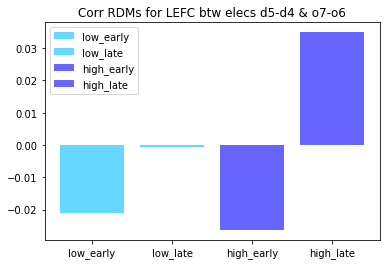

[ 0.07778669 -0.04968048  0.33333333 -0.03030303]


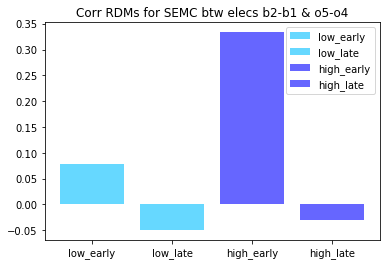

In [148]:
"""
SAME ANALYSIS but only on sig. electrodes (Fig.2)
>> SEE IF OFC PROCESSES ARE CORRELATED WITH HC PROCESSES
>> Compute and Plot correlations for Early/Late and High/Low 
"""
from utils import odor_groups_wgth, odor_groups_3wgth
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd

st = study('Olfacto')
conds, steps = ['low','high'],['early','late']
path_pow = join(st.path, 'feature/TPSim_3groups_'+exp+ \
                        '/similarity_matrix_btw_v=1_elecs=all_early_late/')
filename = join(path_pow, 'TPS_pearson_{}_theta_btw_odors_mean=False_sheet_Final_{}.npz')
save_df = join(path_pow, 'OFC_HC_RDMs/All_subjects_R_aHC_OFC_all_elecs_3patients_{}_{}.csv')

#dict of sig elecs by patient
su_elec_sig = {'LEFC':{'aHC':['b2-b1','b4-b3','d4-d3','d5-d4'],
                      'OFC':['o7-o6']},
               'SEMC':{'aHC':['b2-b1'],
                      'OFC':['o5-o4']},}

#create columns of the global df
subjs, elecs, channels = [], [], []
R_vals, p_vals, pvals_fdr = [], [], []

for su in su_elec_sig:
    nb_pairs = len([a for a,b in product(su_elec_sig[su]['aHC'],
                                         su_elec_sig[su]['OFC'])])
    all_elecs = np.zeros((nb_pairs,4))
    i = 0
    for e1,e2 in product(su_elec_sig[su]['aHC'],su_elec_sig[su]['OFC']):
        all_R, legends = [], []
        for cond,step in product(conds,steps):
            mat = np.load(filename.format(su,step),allow_pickle=True)
            idx_HC = [i for i,chan in enumerate(mat['channels']) if chan == e1]
            idx_OFC = [i for i,chan in enumerate(mat['channels']) if chan == e2]
            
            #select pairs of odors to include
            combs = mat['comb']
            od_sel = [int(x) for x in odor_groups_wgth[su][cond]]
            comb_sel = [str(o1)+'_'+str(o2) for o1,o2 in combinations(od_sel,2)]
            id_comb = [i for i,c in enumerate(combs) if c in comb_sel]
            tps_HC, tps_OFC = mat['tps'][idx_HC,id_comb], mat['tps'][idx_OFC,id_comb]
            comb_rep = combs[id_comb]
            
           # df_ = pd.DataFrame(data=np.concatenate((tps_HC[:,np.newaxis],
            #                    tps_OFC[:,np.newaxis],comb_rep[:,np.newaxis]),axis=1),
            #                  columns=['TPS_HC', 'TPS_OFC', 'combs'])
            #df_['TPS_HC'] = df_['TPS_HC'].astype(float)
            #df_['TPS_OFC'] = df_['TPS_OFC'].astype(float)
            #df2 = df_.groupby(['combs']).mean()
            #R, p = kendalltau(df2['TPS_HC'].values,df2['TPS_OFC'].values)
            R, p = kendalltau(tps_HC,tps_OFC)
            all_R.append(R), legends.append(cond+'_'+step)
        all_elecs[i] = all_R
        i += 1
    
    all_R = np.mean(all_elecs,axis=0)
    print(all_R)
    ax1 = plt.subplot(111)
    colors = ['deepskyblue','deepskyblue','blue','blue']
    for j in range(len(all_R)):
        ax1.bar(j, all_R[j], width=0.8, bottom=0.0, align='center',
            color=colors[j], alpha=0.6, label=legends[j])
    ax1.set_xticks(np.arange(len(all_R)))
    ax1.set_xticklabels(legends)
    ax1.title.set_text('Corr RDMs for {} btw elecs {}'.format(su,str(e1)+' & '+str(e2)))
    ax1.legend()
    plt.show()